In [12]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, TimestampType, StringType
from pyspark.sql.window import Window
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.utils import AnalysisException
import pandas as pd
import datetime
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib
import matplotlib.ticker as ticker


In [ ]:
# spark initialization
spark = SparkSession.builder.appName("gamedata").getOrCreate()
# load master database
hard_sales = spark.read.parquet("../database/parquet/hard_sales")
# hard_info_df = spark.read.parquet("../database/parquet/hard_info")

In [2]:
hard_sales.show()

+-------+----------+----------+------+----+-----+----------+--------+-------------+-----------+---------+----------+----------+---------+----+
|     hw|begin_date|  end_date| units|year|month|launch_day|   maker|    full_name|launch_year|delta_day|delta_week|delta_year|sum_units|week|
+-------+----------+----------+------+----+-----+----------+--------+-------------+-----------+---------+----------+----------+---------+----+
|     GB|1998-10-12|1998-10-18| 10867|1998|   10|1989-04-21|Nintendo|     GAME BOY|       1989|     3467|       495|         9|    10867|  42|
|    N64|1998-10-12|1998-10-18|  2965|1998|   10|1996-06-23|Nintendo|   NINTENDO64|       1996|      847|       121|         2|     2965|  42|
|     PS|1998-10-12|1998-10-18| 20918|1998|   10|1994-12-03|    SONY|  PlayStation|       1994|     1415|       202|         4|    20918|  42|
| SATURN|1998-10-12|1998-10-18|   858|1998|   10|1994-11-22|    SEGA|  SEGA SATURN|       1994|     1426|       203|         4|      858|  42|

In [3]:
hard_sales.filter(F.col("hw") == "Switch").filter(F.col("sum_units") > 1880000).show()

+------+----------+----------+------+----+-----+----------+--------+---------------+-----------+---------+----------+----------+---------+----+
|    hw|begin_date|  end_date| units|year|month|launch_day|   maker|      full_name|launch_year|delta_day|delta_week|delta_year|sum_units|week|
+------+----------+----------+------+----+-----+----------+--------+---------------+-----------+---------+----------+----------+---------+----+
|Switch|2017-10-09|2017-10-15| 37227|2017|   10|2017-03-03|Nintendo|Nintendo Switch|       2017|      226|        32|         0|  1884235|  41|
|Switch|2017-10-16|2017-10-22| 23892|2017|   10|2017-03-03|Nintendo|Nintendo Switch|       2017|      233|        33|         0|  1908127|  42|
|Switch|2017-10-23|2017-10-29|133094|2017|   10|2017-03-03|Nintendo|Nintendo Switch|       2017|      240|        34|         0|  2041221|  43|
|Switch|2017-10-30|2017-11-05| 63977|2017|   11|2017-03-03|Nintendo|Nintendo Switch|       2017|      247|        35|         0|  210519

## Switchの月ごとの販売台数の棒グラフを表示する

In [4]:
hard_sales

DataFrame[hw: string, begin_date: date, end_date: date, units: int, year: int, month: int, launch_day: date, maker: string, full_name: string, launch_year: int, delta_day: int, delta_week: int, delta_year: int, sum_units: bigint, week: int]

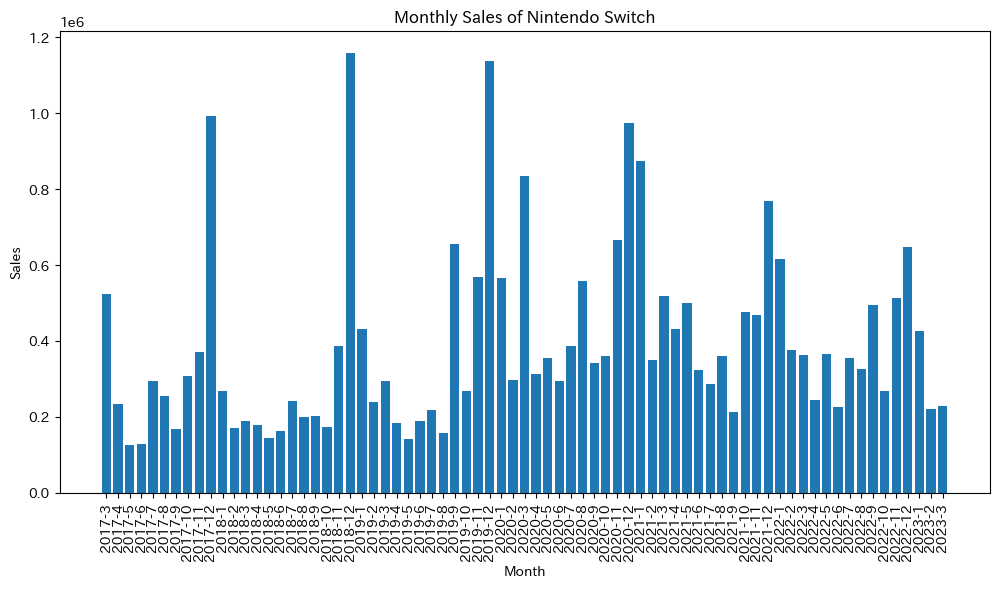

In [6]:
# Switchのデータを抽出
switch_sales = hard_sales.filter(hard_sales.hw == "Switch")

# 月ごとの販売台数を集計
monthly_sales = switch_sales.groupBy("year", "month").agg(F.sum("units").alias("monthly_units")).orderBy("year", "month")

# DataFrameをPandasのDataFrameに変換
monthly_sales_pd = monthly_sales.toPandas()

# グラフの描画
plt.figure(figsize=(12, 6))
plt.bar(monthly_sales_pd.index, monthly_sales_pd['monthly_units'])
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales of Nintendo Switch')
plt.xticks(monthly_sales_pd.index, [f"{row['year']}-{row['month']}" for _, row in monthly_sales_pd.iterrows()], rotation=90)
plt.show()


月ごとのグラフの順序を変更します｡
各年の同じ月の売上を比較したいので､ 2018/1, 2019/1, 2020/1, 2021/1, 2022/1, 2023/1, 2018/2, 2019/2 の
様に各年の同じ月が隣り合うようなグラフを作成します｡

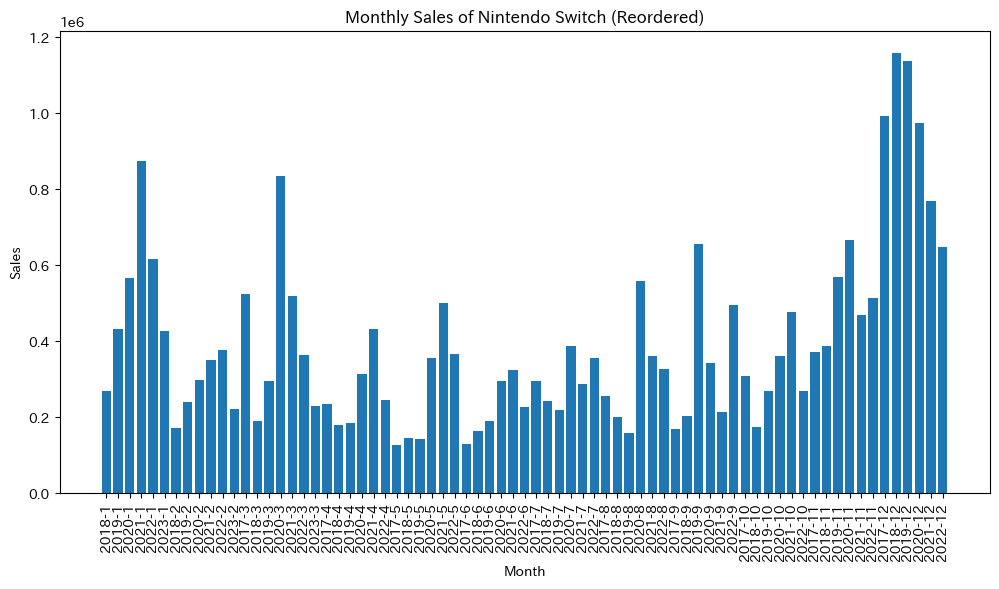

In [7]:
# 月ごとの販売台数を集計
monthly_sales_reordered = monthly_sales.withColumn("month_year", F.concat(F.lpad(monthly_sales["month"], 2, "0"), F.lpad(monthly_sales["year"], 4, "0")))

# 各年の同じ月が隣り合うように並び替え
monthly_sales_reordered = monthly_sales_reordered.orderBy("month_year").drop("month_year")

# DataFrameをPandasのDataFrameに変換
monthly_sales_reordered_pd = monthly_sales_reordered.toPandas()

# グラフの描画
plt.figure(figsize=(12, 6))
plt.bar(monthly_sales_reordered_pd.index, monthly_sales_reordered_pd['monthly_units'])
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales of Nintendo Switch (Reordered)')
plt.xticks(monthly_sales_reordered_pd.index, [f"{row['year']}-{row['month']}" for _, row in monthly_sales_reordered_pd.iterrows()], rotation=90)
plt.show()


In [13]:
def plot_monthly_sales_by_hw(df, hw_name, years):
    filtered_data = df.filter(df["hw"] == hw_name)

    # 年ごとにデータをグループ化し、月別の販売台数を集計
    sales_by_month = filtered_data.groupBy("year", "month").agg(F.sum("units").alias("monthly_units"))

    # PandasのDataFrameに変換
    sales_by_month_pd = sales_by_month.toPandas()

    # 年ごとのデータフレームを格納するリスト
    yearly_dfs = []

    # 指定された年ごとにデータフレームを作成し、リストに追加
    for year in years:
        yearly_data = sales_by_month_pd[sales_by_month_pd['year'] == year]
        yearly_dfs.append(yearly_data)

    # 棒グラフを描画
    plt.figure(figsize=(12, 6))
    width = 0.1

    # 指定された年ごとに棒グラフを描画し、隣り合わせに配置
    for idx, yearly_df in enumerate(yearly_dfs):
        plt.bar(yearly_df['month'] + idx * width, yearly_df['monthly_units'], width=width, label=f'{years[idx]}')

    # x軸の調整と凡例の表示
    plt.xticks(range(1, 13))
    plt.xlabel("Month")
    plt.ylabel("Sales")
    plt.title(f'Monthly Sales of {hw_name} by Year')
    plt.legend()

    # Y軸のメモリを整数表示に変更
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

    plt.show()


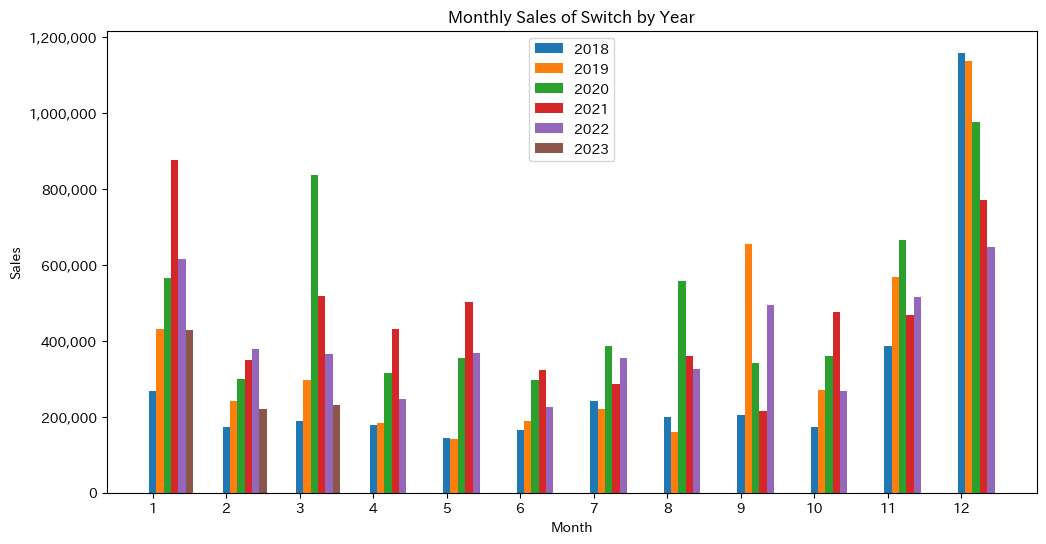

In [15]:
# 関数を使ってSwitchの2017年から2022年までの月ごとの販売台数を表示
plot_monthly_sales_by_hw(hard_sales, "Switch", list(range(2018, 2024)))

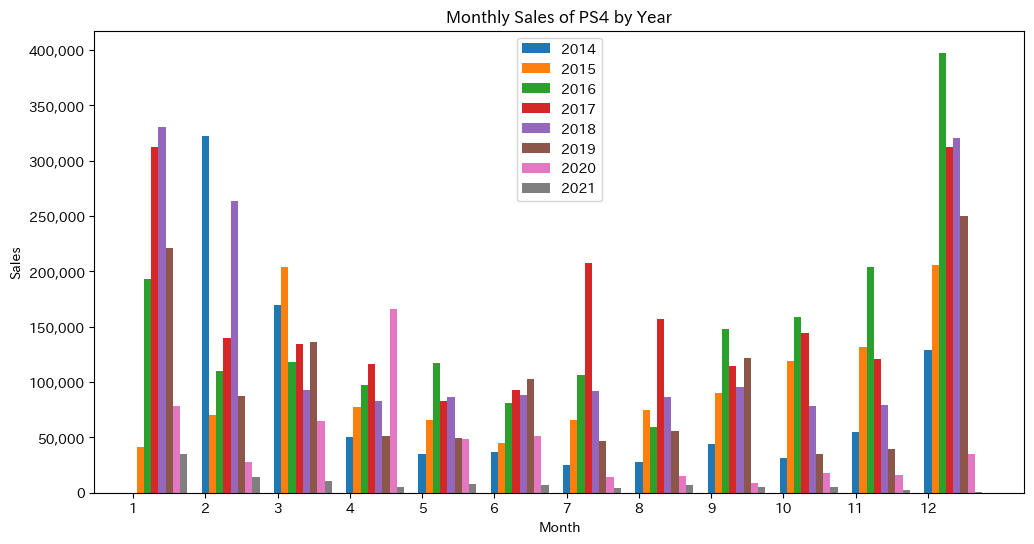

23/04/01 22:01:15 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 320902 ms exceeds timeout 120000 ms
23/04/01 22:01:15 WARN SparkContext: Killing executors is not supported by current scheduler.
23/04/01 22:01:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

In [16]:
plot_monthly_sales_by_hw(hard_sales, "PS4", list(range(2014, 2022)))